## Importing libraries, parameters.py

In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = '/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=/home/yoda/Aron/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully c

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import time   # runtime measurement
import random   # random number generator
from multiprocessing import Pool, cpu_count   # multithreading
import importlib   # reload changes you made
import json   # convert dictionary to string

# my own file:
already_imported = 'gd' in globals()
try:
    import gradient_descent as gd
except:
    try:
        import Bubble_dynamics_simulation.gradient_descent as gd
    except:
        print(colored(f'Error, \'gradient_descent.py\' not found', 'red'))
if already_imported: importlib.reload(gd)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


## Define ranges

In [3]:
"""Control parameter ranges and division"""
# a list for each control parameter, containing all the possible values

ranges = dict(
  # Initial conditions:
    # bubble equilibrium radius [m]
    R_E = [1.0e-6*x for x in [1.0, 500.0]], # [um --> m]
    # initial radius / equilibrium radius R_0/R_E [-]
    ratio = [1.0],
    # indexes of species in initial bubble
    gases=[[par.index['N2'], par.index['H2']]],
    # Molar fractions of species in the initial bubble (H2 and N2) [-]
    fractions=[[0.25, 0.75]],
  # Ambient parameters:
    # ambient pressure [Pa]
    P_amb = [x * par.atm2Pa for x in [1.0]], # [atm --> Pa]
    # ambient temperature [K]       
    T_inf = [par.absolute_zero + x for x in [30.0]], # [°C --> K]
  # Liquid parameters:
    # water accommodation coefficient [-]
    alfa_M = [0.35],
    # vapour pressure [Pa] - will be calculated from T_inf
    P_v = [par.P_v],
    # dynamic viscosity [Pa*s] - will be calculated from T_inf
    mu_L = [par.mu_L],
    # sound speed [m/s]
    c_L = [par.c_L],
    # surfactant (surface tension modfier) [-]
    surfactant = [1.0],
  # Excitation parameters: (excitation_type = no_excitation)
    p_A = [1e5*x for x in [0.5, 4.0]], # pressure amplitude [Pa]
    logf = [3.0, 6.0], # frequency [Hz]
    n = [1.0]
)

for key in gd.de.excitation_args:
    if key not in ranges:
        print(colored(f'Error, {key} not in ranges', 'red'))

Starting the searches from random points is not a good practice. You may start them from the best points of a bruteforce search. Alternatively, you can use trial_points, and only use the best searches points as start points.

In [4]:
# create folder for parameter study results:
save_path = '/home/yoda/Aron/parameter_studies/Excitation_search/sin_impulse_inverse'
file = gd.de.Make_dir(save_path)
to_optimize = 'energy_efficiency'   # key in data from de.get_data()
searches = 30    # number os total searches
trial_points = 5000  # number of trial start_points. best ones will be used for searches


kwargs_list = [
    dict(
        point=gd.rand_point(ranges, ID=i, padding=0.1),
        to_optimize=to_optimize,
        t_int=[0.0, 1.0],
        LSODA_timeout=30,
        Radau_timeout=300,
    )
for i in range(trial_points)]
best_energy_efficiency = 1e30
start_points = []

start = time.time()
file.new_file()
with Pool(processes=cpu_count(), maxtasksperchild=100) as pool:
    results = pool.imap_unordered(gd.evaluate_kwargs, kwargs_list)

    for result in results:
        data, point, success = result
        data = gd.de.dotdict(data)
        file.write_line(data)
        start_points.append(point)
      # print stuff:
        if data.energy_efficiency > 0 and data.energy_efficiency < best_energy_efficiency:
            best_energy_efficiency = data.energy_efficiency
        to_print = [f'{key}={data[key]: e};   ' for key in ranges if len(ranges[key]) == 2]
        to_print = ''.join(to_print)
        print(f'index: {data.ID: >8}/{len(kwargs_list)};   success: {success};   runtime: {data.elapsed_time: 6.2f} [s]   |   ' + to_print + '|   ' +
              f'{gd.de.target_specie} production: {data.energy_efficiency: e} [MJ/kg] (best: {best_energy_efficiency: .1f} [MJ/kg])'+
              '                                                 ', end='\r')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\nDONE')
print(f'total time: {elapsed: .2f} [s]   ({(elapsed / len(kwargs_list)): .2f} [s/run])')

best energy_efficiency:  1.696208e+03 [MJ/kg]
30th energy_efficiency:  2.234476e+03 [MJ/kg]


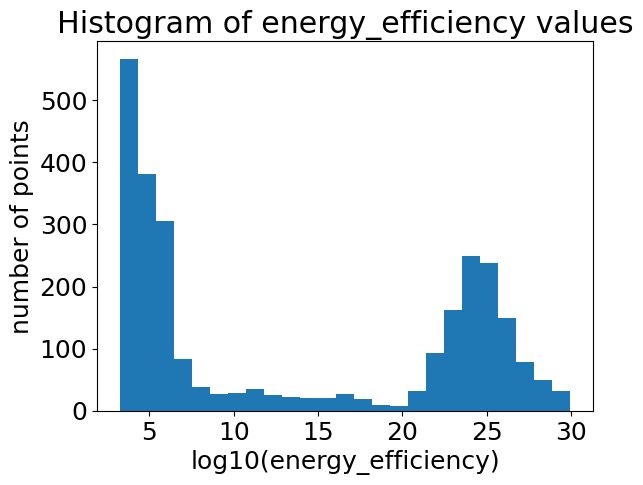

In [ ]:

start_points.sort(key=lambda point: point['output'])
outputs = [np.log10(point['output']) for point in start_points if point['output'] < 1e30]
print(f'best energy_efficiency: {start_points[0]["output"]: e} [MJ/kg]')
print(f'{searches}th energy_efficiency: {start_points[searches-1]["output"]: e} [MJ/kg]')
plt.hist(outputs, bins=25)
plt.xlabel('log10(energy_efficiency)')
plt.ylabel('number of points')
plt.title('Histogram of energy_efficiency values')
plt.show()

In [ ]:
ranges2 = gd.de.copy(ranges)
for key in ranges:
    if len(ranges[key]) != 2:
        continue
    
    values = [point[key] for point in start_points[:searches]]
    ranges2[key][0] = min(values)
    ranges2[key][1] = max(values)
    print(f'old {key}: {ranges[key][1]-ranges[key][0]: e}')
    print(f'new {key}: {ranges2[key][1]-ranges2[key][0]: e}')

old R_E:  4.990000e-04
new R_E:  1.944251e-04
old p_A: -3.500000e+05
new p_A:  2.956411e+05
old logf:  3.000000e+00
new logf:  7.452322e-01


In [ ]:
ranges2

{'R_E': [5.2064597616238134e-05, 0.0002464896909248239],
 'ratio': [1.0],
 'gases': [[11, 1]],
 'fractions': [[0.25, 0.75]],
 'P_amb': [101325.0],
 'T_inf': [303.15],
 'alfa_M': [0.35],
 'P_v': [2338.1],
 'mu_L': [0.001],
 'c_L': [1483.0],
 'surfactant': [1.0],
 'p_A': [-428675.8323395383, -133034.7024582773],
 'logf': [3.8220161206909404, 4.5672482814651865],
 'n': [4.0]}

In [ ]:
kwargs_list = [dict(
    ranges=ranges2,
    path=save_path,
    to_optimize=to_optimize,
    start_point=start_point,
    step_limit=200,
    max_step_until_decay=20,
    first_step=0.01,
    min_step=10e-5,
    decay=0.5,
    delta=1e-6,
    verbose=False,
    t_int=[0.0, 1.0],
    LSODA_timeout=30,
    Radau_timeout=300,
    ) for start_point in start_points[:searches]]

# Run gradient_search() multithread

In [ ]:
"""Save settings as txt"""

# save all settings (full_bubble_model.py, parameters.py, ranges) as txt:
to_print = gd.de.copy(kwargs_list[0])
del to_print['ranges']
del to_print['start_point']
ranges_str = f'''
gradient descent general settings:
    to_optimize = '{to_optimize}'   # key in data from de.get_data()
    searches = {searches}    # number os total searches
    trial_points = {trial_points}  # number of trial start_points. best ones will be used for searches

ranges = {json.dumps(ranges, indent=4)}

settings = {json.dumps(to_print, indent=4)}

start_points = [
'''

for kwargs in kwargs_list[:searches]:
    ranges_str += json.dumps(kwargs['start_point'], indent=4) + ',\n'
ranges_str += ']'

file.write_string(ranges_str, 'gradient_descent_settings')

In [ ]:
"""Gradient descent, multithread"""

best_output = 1.0e30
num = 0
to_plot = []
last_points = []
start = time.time()

with Pool(processes=cpu_count(), maxtasksperchild=1) as pool:
    results = pool.imap_unordered(gd.search, kwargs_list)
    for result in results:
        last_data, best_outputs, elapsed = result
        num += 1
        to_plot.append(best_outputs)
        last_points.append(last_data)
        if best_outputs[-1] < best_output and best_outputs[-1] > 0:
            best_output = best_outputs[-1]
        
        # print stuff:
        print(f'{num: >3}/{searches}: Total {len(best_outputs): <3} steps, finished in {elapsed: 8.2f} [s]   ({(elapsed / len(best_outputs)): 4.2f} [s/step]).   '+
              f'Final {to_optimize}: {best_outputs[-1]: 8.1f} (best: {best_output: 6.1f})')
            
file.close()
end = time.time()
elapsed = end - start
print(f'\n\nDONE')
print(f'total time: {((elapsed-elapsed % 3600) / 3600): .0f} hours {((elapsed % 3600) / 60): .0f} mins')
print(f'            {elapsed: .2f} [s]   ({(elapsed / searches): .2f} [s/search])')

Folder already exists with 1 csv in it
Folder already exists with 2 csv in it
Folder already exists with 3 csv in it
Folder already exists with 4 csv in it
Folder already exists with 5 csv in it
Folder already exists with 6 csv in it
Folder already exists with 7 csv in it
Folder already exists with 8 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3026542007947D+00   r2 =  0.2366602075410D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3026542007947D+00   r2 =  0.2366602075410D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.30265420079

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4424883776947D+00   r2 =  0.1667741870431D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2036374416228D-04   r2 =  0.1635602598982D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2036374416228D-04   r2 =  0.1635602598982D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2036374416228D-04   r2 =  0.1635602598982D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2036374416228D-04   r2 =  0.1245005451485D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3236930680986D+00   r2 =  0.2621200083971D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3236930680986D+00   r2 =  0.2621200083971D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3236930680986D+00   r2 =  0.2621200083971D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3236930680986D+00   r2 =  0.2621200083971D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6859755424913D-01   r2 =  0.6302499999402D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9368866423768D-01   r2 =  0.6675232950318D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9368866423768D-01   r2 =  0.6675232950318D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9368866423768D-01   r2 =  0.6675232950318D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9368866423768D-01   r2 =  0.6675232950318D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  1/30: Total 23  steps, finished in   853.18 [s]   ( 37.09 [s/step]).   Final energy_efficiency:   1638.9 (best:  1638.9)
Folder already exists with 9 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1418706694323D+00   r2 =  0.1326450025308D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1418706694323D+00   r2 =  0.1326450025308D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1418706694323D+00   r2 =  0.1326450025308D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.9793471867439D+00   r2 =  0.4822123158000D-16
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9793471867487D+00   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3608762854536D+00   r2 =  0.1322256684502D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5467804115917D+00   r2 =  0.1643345122065D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5467804115917D+00   r2 =  0.1643345122065D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5467804115917D+00   r2 =  0.1643345122065D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2144170828235D+00   r2 =  0.1024315061431D-06
  2/30: Total 69  steps, finished in  2087.10 [s]   ( 30.25 [s/step]).   Final energy_efficiency:   1847.9 (best:  1638.9)
Folder already exists with 10 csv in it


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.7644149729434D+00   r2 =  0.2693576815968D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1123629817394D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1123629817394D+00   r2 =                  NaN
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.1123629817394D+00   r2 =                  NaN
  3/30: Total 68  steps, finished in  2288.47 [s]   ( 33.65 [s/step]).   Final energy_efficiency:   1798.9 (best:  1638.9)
Folder already exists with 11 csv in it
  4/30: Total 72  steps, finished in  2415.46 [s]   ( 33.55 [s/step]).   Final energy_efficiency:   1648.8 (best:  1638.9)
Folder already exists with 12 csv in it


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9088649329167D+00   r2 =  0.5895310742418D-08


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2092767716898D+00   r2 =  0.1299240181231D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2092767716898D+00   r2 =  0.1299240181231D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2092767716898D+00   r2 =  0.1299240181231D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2092767716898D+00   r2 =  0.1299240181231D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1856216994078D-04   r2 =  0.1393066797436D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1856216994078D-04   r2 =  0.1393066797436D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1856216994078D-04   r2 =  0.1393066797436D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1856216994078D-04   r2 =  0.1054576794497D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  5/30: Total 18  steps, finished in   600.35 [s]   ( 33.35 [s/step]).   Final energy_efficiency:   1395.2 (best:  1395.2)
Folder already exists with 13 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6216425741409D-01   r2 =  0.3012620886243D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6216425741409D-01   r2 =  0.3012620886243D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6216425741409D-01   r2 =  0.3012620886243D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6317734326917D-01   r2 =  0.6711918515405D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6317734326917D-01   r2 =  0.6711918515405D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6317734326917D-01   r2 =  0.6711918515405D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6317734326917D-01   r2 =  0.6711918515405D-17
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  6/30: Total 97  steps, finished in  3113.20 [s]   ( 32.09 [s/step]).   Final energy_efficiency:   1733.6 (best:  1395.2)
Folder already exists with 14 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1053578476196D-04   r2 =  0.7284127739338D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1053578476196D-04   r2 =  0.7284127739338D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1053578476196D-04   r2 =  0.5896244500586D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5888258487780D+00   r2 =  0.5152244865478D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3648515590608D+00   r2 =  0.2753698694046D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3648515590608D+00   r2 =  0.2753698694046D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3648515590608D+00   r2 =  0.2753698694046D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3648515590608D+00   r2 =  0.2753698694046D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  7/30: Total 117 steps, finished in  3883.17 [s]   ( 33.19 [s/step]).   Final energy_efficiency:   1710.0 (best:  1395.2)
Folder already exists with 15 csv in it
  8/30: Total 120 steps, finished in  3951.25 [s]   ( 32.93 [s/step]).   Final energy_efficiency:   1705.8 (best:  1395.2)
Folder already exists with 16 csv in it


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.9986744243117D+00   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5367096067930D+00   r2 =  0.3897942858680D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4052772053213D+00   r2 =  0.5751903895359D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


  9/30: Total 122 steps, finished in  4193.18 [s]   ( 34.37 [s/step]).   Final energy_efficiency:   1781.9 (best:  1395.2)
Folder already exists with 17 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.4891040037051D+00   r2 =  0.2457503030351D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6614570391915D+00   r2 =  0.5051896872749D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6614570391915D+00   r2 =  0.5051896872749D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6614570391915D+00   r2 =  0.5051896872749D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6614570391915D+00   r2 =  0.5051896872749D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5534325628733D+00   r2 =  0.2385331451052D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5534325628733D+00   r2 =  0.2385331451052D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.7870559625053D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.7870559625053D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.6548970909198D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.7870559625053D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.7870559625053D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.6548970909198D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1207799785804D-04   r2 =  0.6548970909198D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 11/30: Total 39  steps, finished in  1669.22 [s]   ( 42.80 [s/step]).   Final energy_efficiency:   1978.4 (best:  1395.2)
Folder already exists with 19 csv in it
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2224391282838D+00   r2 =  0.1614353779298D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.5089974043976D+00   r2 =  0.3282260273545D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1073878355346D-04   r2 =  0.6833533698023D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1073878355346D-04   r2 =  0.6833533698023D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1073878355346D-04   r2 =  0.5656891336785D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2224391282838D+00   r2 =  0.1614353779298D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1424174816937D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1424174816937D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1424174816937D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1074632111096D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1424174816937D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1424174816937D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1424174816937D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1592402221639D-04   r2 =  0.1074632111096D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4418671176722D+00   r2 =  0.2497165431556D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6375927508277D+00   r2 =  0.1411764394686D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4418671176722D+00   r2 =  0.2497165431556D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4418671176722D+00   r2 =  0.2497165431556D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2638988195701D+00   r2 =  0.2048733706813D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4333363059760D+00   r2 =  0.1181826466666D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6560219925530D+00   r2 =  0.5744836511570D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6560219925530D+00   r2 =  0.5744836511570D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.6560219925530D+00   r2 =  0.5744836511570D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7254893147556D-05   r2 =  0.3898009729540D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
    

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7254893147556D-05   r2 =  0.3898009729540D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7254893147556D-05   r2 =  0.3898009729540D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7254893147556D-05   r2 =  0.3159505974526D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7254893147556D-05   r2 =  0.3159505974526D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2433214675720D-04   r2 =  0.1535741653991D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2433214675720D-04   r2 =  0.1535741653991D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2433214675720D-04   r2 =  0.1535741653991D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2433214675720D-04   r2 =  0.1178931211876D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7545411661704D-05   r2 =  0.4217390486648D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7545411661704D-05   r2 =  0.4217390486648D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7545411661704D-05   r2 =  0.3493617323162D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.7545411661704D-05   r2 =  0.3493617323162D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4827161831909D+00   r2 =  0.2347766016763D-06
 13/30: Total 93  steps, finished in  3079.56 [s]   ( 33.11 [s/step]).   Final energy_efficiency:   1724.3 (best:  1395.2)
Folder already exists with 21 csv in it
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4827161831909D+00   r2 =  0.2347766016763D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1173542666950D+00   r2 =  0.6548540147538D-17
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 14/30: Total 99  steps, finished in  3453.58 [s]   ( 34.88 [s/step]).   Final energy_efficiency:   1948.2 (best:  1395.2)
Folder already exists with 22 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1246394451482D-20
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4651400380719D+00   r2 =  0.3092869839290D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4651400380719D+00   r2 =  0.3092869839290D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1617556635122D-04   r2 =  0.1653610423482D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


Folder already exists with 23 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3309770259575D+00   r2 =  0.2333390619108D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3309770259575D+00   r2 =  0.2333390619108D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3309770259575D+00   r2 =  0.2333390619108D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3309770259575D+00   r2 =  0.2333390619108D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2998174705565D+00   r2 =  0.2389871767002D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2998174705565D+00   r2 =  0.2389871767002D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2998174705565D+00   r2 =  0.2389871767002D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2998174705565D+00   r2 =  0.2389871767002D-16
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: Use

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5541180815928D+00   r2 =  0.2504605294501D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5541180815928D+00   r2 =  0.5009210589003D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5541180815928D+00   r2 =  0.5009210589003D-16
 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.5541180815978D+00   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.3543828395498D+00   r2 =  0.1613194878723D-06
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.2536710309674D+00   r2 =  0.1114515684211D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8123545150144D+00   r2 =  0.2350062172699D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.8123545150144D+00   r2 =  0.4700124345399D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 16/30: Total 25  steps, finished in   813.93 [s]   ( 32.56 [s/step]).   Final energy_efficiency:   1916.6 (best:  1395.2)
Folder already exists with 24 csv in it


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5604530974937D+00   r2 =  0.5115960259297D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5604530974937D+00   r2 =  0.5115960259297D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5604530974937D+00   r2 =  0.5115960259297D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5604530974937D+00   r2 =  0.5115960259297D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3052372767378D-04   r2 =  0.3232625188708D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3052372767378D-04   r2 =  0.3232625188708D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3052372767378D-04   r2 =  0.3232625188708D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3052372767378D-04   r2 =  0.2548482829139D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 17/30: Total 46  steps, finished in  1603.67 [s]   ( 34.86 [s/step]).   Final energy_efficiency:   1883.1 (best:  1395.2)
Folder already exists with 25 csv in it
 18/30: Total 79  steps, finished in  3452.10 [s]   ( 43.70 [s/step]).   Final energy_efficiency:   1789.3 (best:  1395.2)
Folder already exists with 26 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794899736556D-04   r2 =  0.1652404685024D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2794899736556D-04   r2 =  0.1652404685024D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 = 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 20/30: Total 54  steps, finished in  1750.65 [s]   ( 32.42 [s/step]).   Final energy_efficiency:   1699.7 (best:  1395.2)
Folder already exists with 28 csv in it


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.6301049409824D+00   r2 =                  NaN


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 21/30: Total 118 steps, finished in  3729.57 [s]   ( 31.61 [s/step]).   Final energy_efficiency:   1992.2 (best:  1395.2)
Folder already exists with 29 csv in it
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3928408240232D-04   r2 =  0.2681115213355D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3928408240232D-04   r2 =  0.2681115213355D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3928408240232D-04   r2 =  0.2681115213355D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9595966034739D+00   r2 =  0.3082534524999D-07


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476954505335D-04   r2 =  0.6843642955563D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476954505335D-04   r2 =  0.6843642955563D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476954505335D-04   r2 =  0.6843642955563D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476954505335D-04   r2 =  0.5126341823948D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400601613881D-04   r2 =  0.1510291758848D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400601613881D-04   r2 =  0.1510291758848D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400601613881D-04   r2 =  0.1510291758848D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2400601613881D-04   r2 =  0.1141592893077D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2025593095098D-04   r2 =  0.1521944918477D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2025593095098D-04   r2 =  0.1521944918477D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2025593095098D-04   r2 =  0.1521944918477D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2025593095098D-04   r2 =  0.1161234311421D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4526505497612D+00   r2 =  0.1704245044488D-06


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1168965790565D-04   r2 =  0.6640644741503D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1168965790565D-04   r2 =  0.6640644741503D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1168965790565D-04   r2 =  0.6640644741503D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1168965790565D-04   r2 =  0.4967038599560D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.8311482906345D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.8311482906345D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.6900860626633D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.6900860626633D-21
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4286213020212D+00   r2 =  0.1452985959868D-06


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.8311482906345D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.8311482906345D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.6900860626633D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.6900860626633D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.8311482906345D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.8311482906345D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.6900860626633D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1516869889847D-04   r2 =  0.6900860626633D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010076450950D-04   r2 =  0.1542979491683D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010076450950D-04   r2 =  0.1542979491683D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010076450950D-04   r2 =  0.1542979491683D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3010076450950D-04   r2 =  0.1189157329495D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.6058021530848D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.6058021530848D-21
 lsoda--  warning..internal t (=r1) 

/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3977049985148D+00   r2 =                  NaN


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1), too much accuracy requested    
       for precision of machine..  see tolsf (=r2)   
      in above,  r1 =  0.3977049985148D+00   r2 =                  NaN
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1443655087099D-04   r2 =  0.8088098581691D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t o

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4239359201974D+00   r2 =  0.1678452651831D-06
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803492091759D+00   r2 =  0.2394158700714D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803492091759D+00   r2 =  0.2394158700714D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2803492091759D+00   r2 =  0.2394158700714D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 22/30: Total 37  steps, finished in  1533.68 [s]   ( 41.45 [s/step]).   Final energy_efficiency:   2120.5 (best:  1395.2)
Folder already exists with 30 csv in it
 23/30: Total 53  steps, finished in  2395.20 [s]   ( 45.19 [s/step]).   Final energy_efficiency:   2127.6 (best:  1395.2)


capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 24/30: Total 128 steps, finished in  4340.00 [s]   ( 33.91 [s/step]).   Final energy_efficiency:   2012.8 (best:  1395.2)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2166990269546D-04   r2 =  0.1512369534060D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2166990269546D-04   r2 =  0.1512369534060D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2166990269546D-04   r2 =  0.1512369534060D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will co

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1116184303393D-04   r2 =  0.7695482628732D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1116184303393D-04   r2 =  0.7695482628732D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1116184303393D-04   r2 =  0.7695482628732D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1116184303393D-04   r2 =  0.5930248460458D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2204981244699D-04   r2 =  0.1555330895281D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2204981244699D-04   r2 =  0.1555330895281D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2204981244699D-04   r2 =  0.1555330895281D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2204981244699D-04   r2 =  0.1187012177331D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 25/30: Total 59  steps, finished in  1884.73 [s]   ( 31.94 [s/step]).   Final energy_efficiency:   1915.1 (best:  1395.2)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2287372918323D+00   r2 =  0.1212161439996D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will co

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8656324508946D+00   r2 =  0.6708449509471D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:338: RuntimeWarning: overflow encountered in multiply
  new_factor = NUM_JAC_FACTOR_INCREASE * factor[ind]
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ivp/common.py:360: RuntimeWarning: overflow encountered in multiply
  factor[max_diff < NUM_JAC_DIFF_SMALL * scale] *= NUM_JAC_FACTOR_INCREASE


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8656324508946D+00   r2 =  0.6708449509471D-07
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8656324508946D+00   r2 =  0.6708449509471D-07


/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.4696953817361D+00   r2 =  0.1776393640887D-06
 26/30: Total 71  steps, finished in  2628.67 [s]   ( 37.02 [s/step]).   Final energy_efficiency:   1884.8 (best:  1395.2)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2153471170132D-04   r2 =  0.1465512536344D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2153471170132D-04   r2 =  0.1465512536344D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in abo

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.
/home/yoda/.local/lib/python3.10/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Repeated convergence failures (perhaps bad Jacobian or tolerances).
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8087083827007D+00   r2 =  0.7101004947544D-07
 27/30: Total 134 steps, finished in  4180.38 [s]   ( 31.20 [s/step]).   Final energy_efficiency:   2035.8 (best:  1395.2)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in abo

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1003196041322D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.8112689494085D+00   r2 =  0.8720754261522D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2307667438206D-04   r2 =  0.1330606300920D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2292449004266D-04   r2 =  0.1312092988996D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2292449004266D-04   r2 =  0.1312092988996D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2292449004266D-04   r2 =  0.1312092988996D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2292449004266D-04   r2 =  0.9891186232374D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2241124684721D-04   r2 =  0.1638904637318D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2241124684721D-04   r2 =  0.1638904637318D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2241124684721D-04   r2 =  0.1638904637318D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2241124684721D-04   r2 =  0.1250152946244D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2275028839935D-04   r2 =  0.1672289022183D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2275028839935D-04   r2 =  0.1672289022183D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2275028839935D-04   r2 =  0.1672289022183D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2275028839935D-04   r2 =  0.1273666298532D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin    l
      in above,  r1 =  0.9701939958506D+00   r2 =  0.2274017650561D-07
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476896058981D-04   r2 =  0.7276006083275D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476896058981D-04   r2 =  0.7276006083275D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1476896058981D-04   r2 =  0.6039282726557D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       suc

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1299241922661D-04   r2 =  0.6447751812072D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1299241922661D-04   r2 =  0.6447751812072D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1299241922661D-04   r2 =  0.5350333192063D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1299241922661D-04   r2 =  0.5350333192063D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400503934908D-04   r2 =  0.6482012424944D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400503934908D-04   r2 =  0.6482012424944D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400503934908D-04   r2 =  0.5359701610031D-21
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1400503934908D-04   r2 =  0.5359701610031D-21
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 29/30: Total 140 steps, finished in  4390.22 [s]   ( 31.36 [s/step]).   Final energy_efficiency:   2054.9 (best:  1395.2)
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2302012282044D-04   r2 =  0.1509090005236D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2302012282044D-04   r2 =  0.1509090005236D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2302012282044D-04   r2 =  0.1509090005236D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will co

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1000964670915D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1000964670915D-20
 lsoda--  warning..internal t (=r1) 

capi_return is NULL
Call-back cb_f_in_lsoda__user__routines failed.


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1326229675209D-20
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.2127340861911D-04   r2 =  0.1000964670915D-20
 lsoda--  warning..internal t (=r1) 

## Plot results

In [30]:
[(len(x), x[-1]) for x in to_plot if x[-1]<1800]

[(23, 1638.9116270635204),
 (68, 1798.879353699489),
 (72, 1648.7654841014107),
 (18, 1395.1951127415523),
 (97, 1733.603738072582),
 (117, 1709.9739243352337),
 (120, 1705.789754551842),
 (122, 1781.8554837016309),
 (93, 1724.319563877042),
 (79, 1789.3430785965418),
 (54, 1699.6837757272972)]

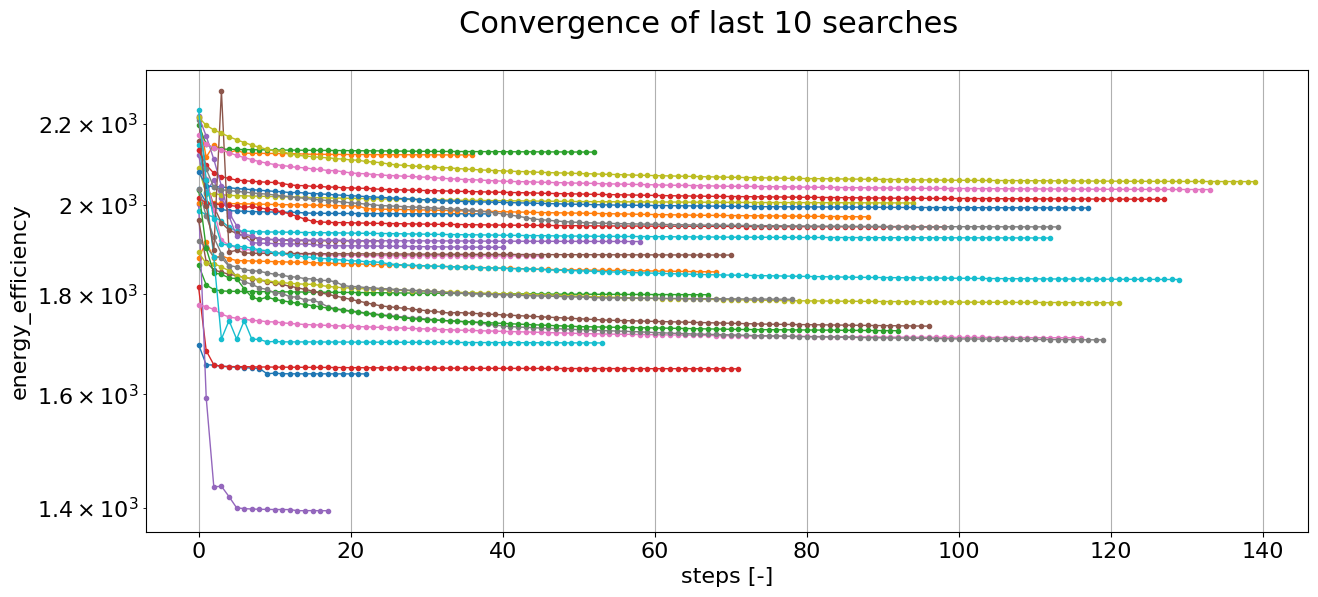

In [32]:
"""Plot convergence of last searches"""

if len(to_plot) > 10:
    to_plot2 = to_plot[:]
else:
    to_plot2 = to_plot

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
fig.suptitle('Convergence of last 10 searches', fontsize=22)
ax.set_ylabel(f'{to_optimize}')
#ax.set_ylim(0.99*best_output, 1.15*best_output)
ax.set_yscale('log')
ax.set_xlabel('steps [-]')
ax.grid()
for plot in to_plot2:
    ax.plot(plot, '.-', linewidth=1.0)
plt.show()

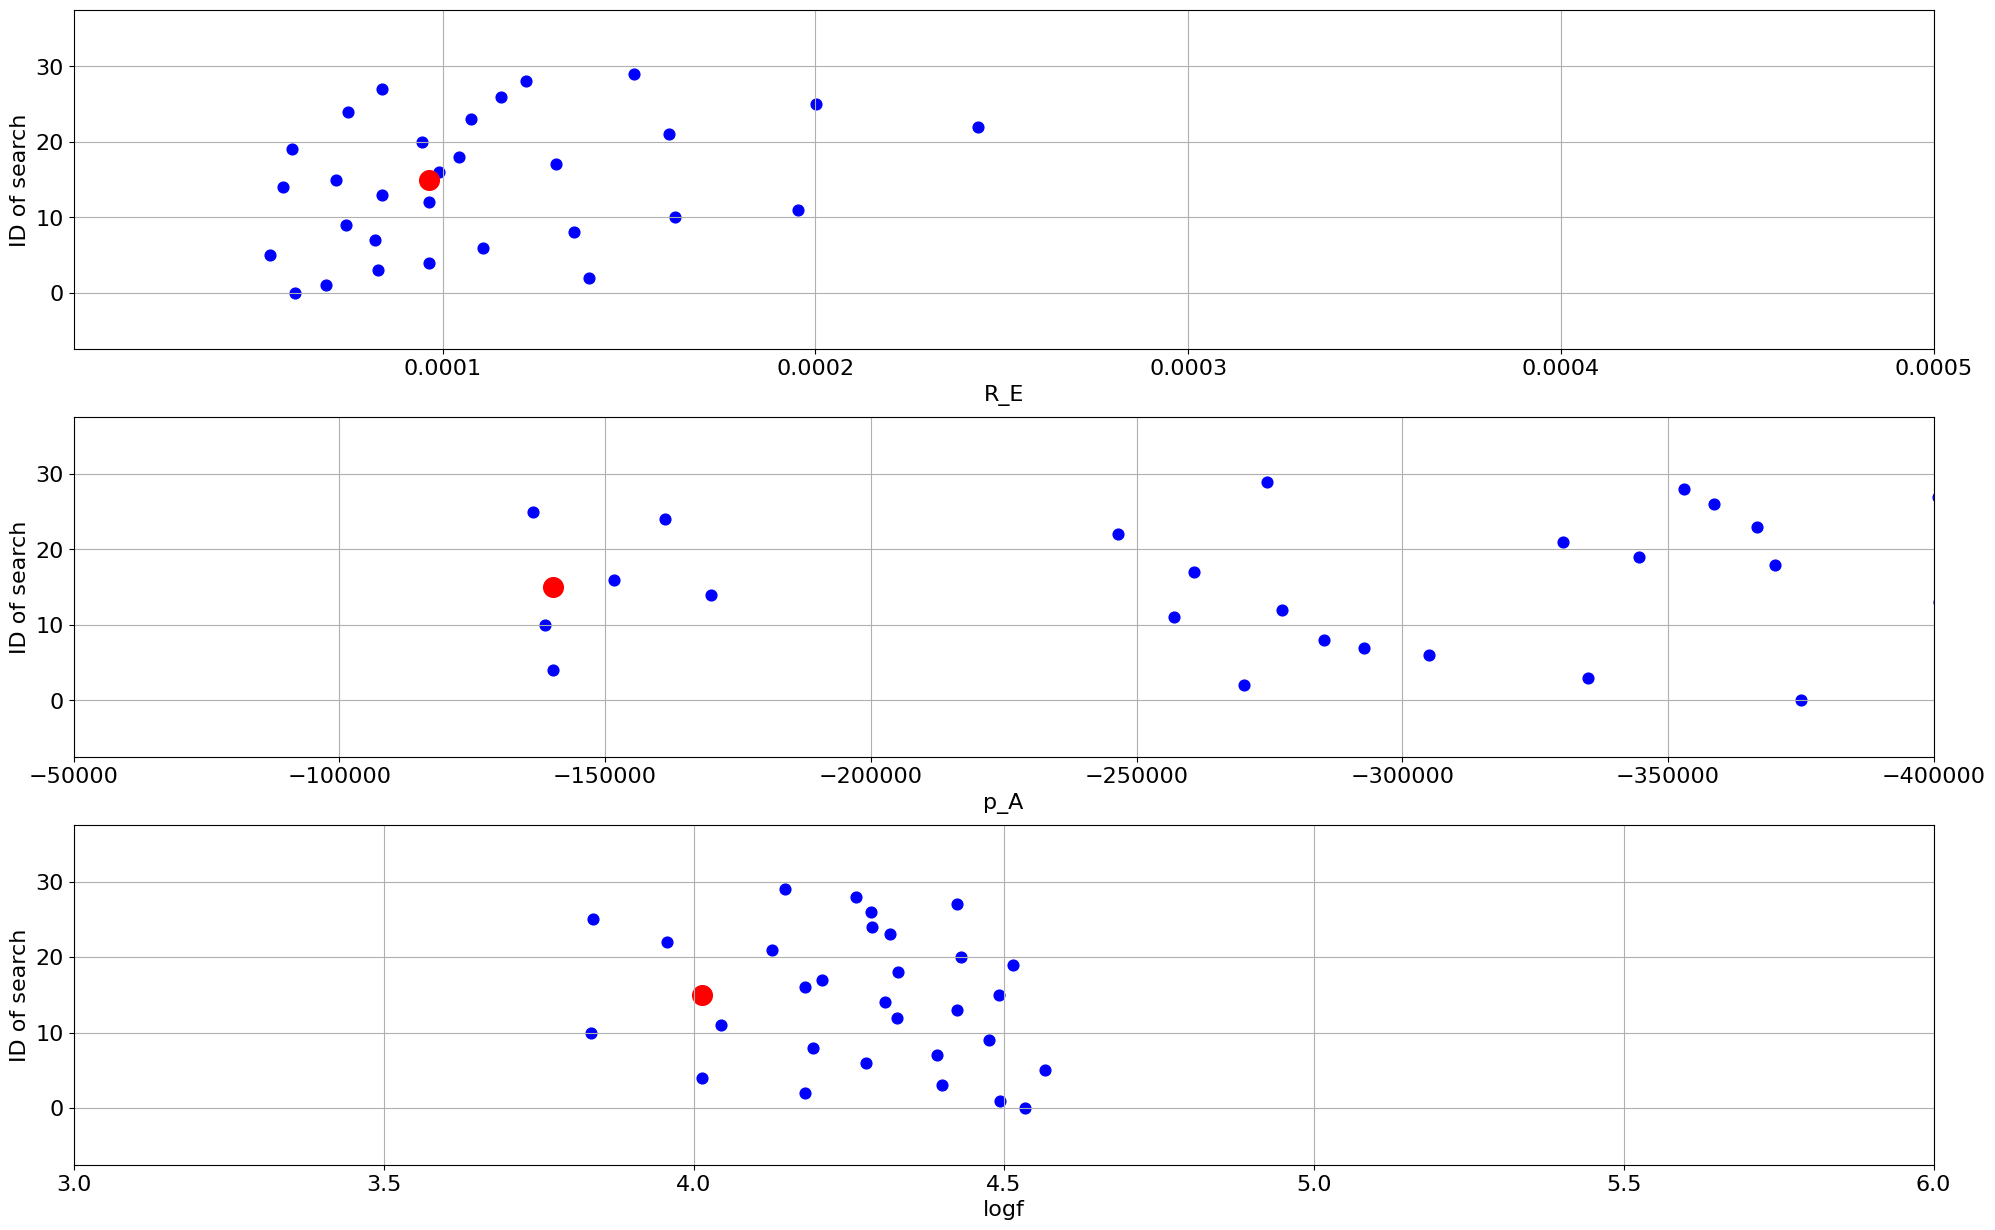

In [33]:
"""Plot the distribution of the optimums"""

plt.rcParams.update({'font.size': 16})
ranges2 = dict()
for key in ranges:
    if len(ranges[key]) > 1:
        ranges2[key] = ranges[key]

n = len(ranges2)
fig, ax = plt.subplots(n, 1, figsize=(24, 5*n))
for i, key in enumerate(ranges2):
    last_values = [last_point[key] for last_point in last_points]
    y = [i for i, last_point in enumerate(last_points)]
        
  # ploting:
    ax[i].scatter(last_values, y, s=60, color='b')
    ax[i].set_ylabel('ID of search')
    ax[i].set_xlabel(key)
    ax[i].set_xlim(ranges2[key])
    n = len(last_points)
    ax[i].set_ylim([-0.25*n, 1.25*n])
    ax[i].grid()
    # best point:
    index = [x[-1] for x in to_plot].index(best_output)
    best_point = last_points[index]
    ax[i].scatter([best_point[key]], [0.5*n], s=200, color='r')
